<a href="https://colab.research.google.com/github/PollyBecker/Autoencoders/blob/main/Remo%C3%A7%C3%A3o_de_ru%C3%ADdo_de_imagens_com_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Remoção de ruído de imagens

Artigo: https://www.corvil.com/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

# Etapa 1: Importação das bibliotecas

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.13.0'

# Etapa 2: Carregamento da base de dados

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


# Etapa 3: Visualização dos dados

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

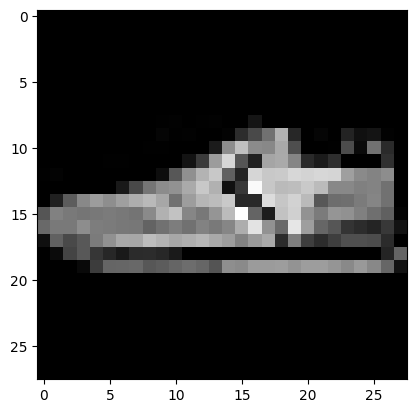

In [ ]:
i = random.randint(0,60000)
plt.imshow( X_train[i] , cmap = 'gray')

In [ ]:
label = y_train[i]
label

7

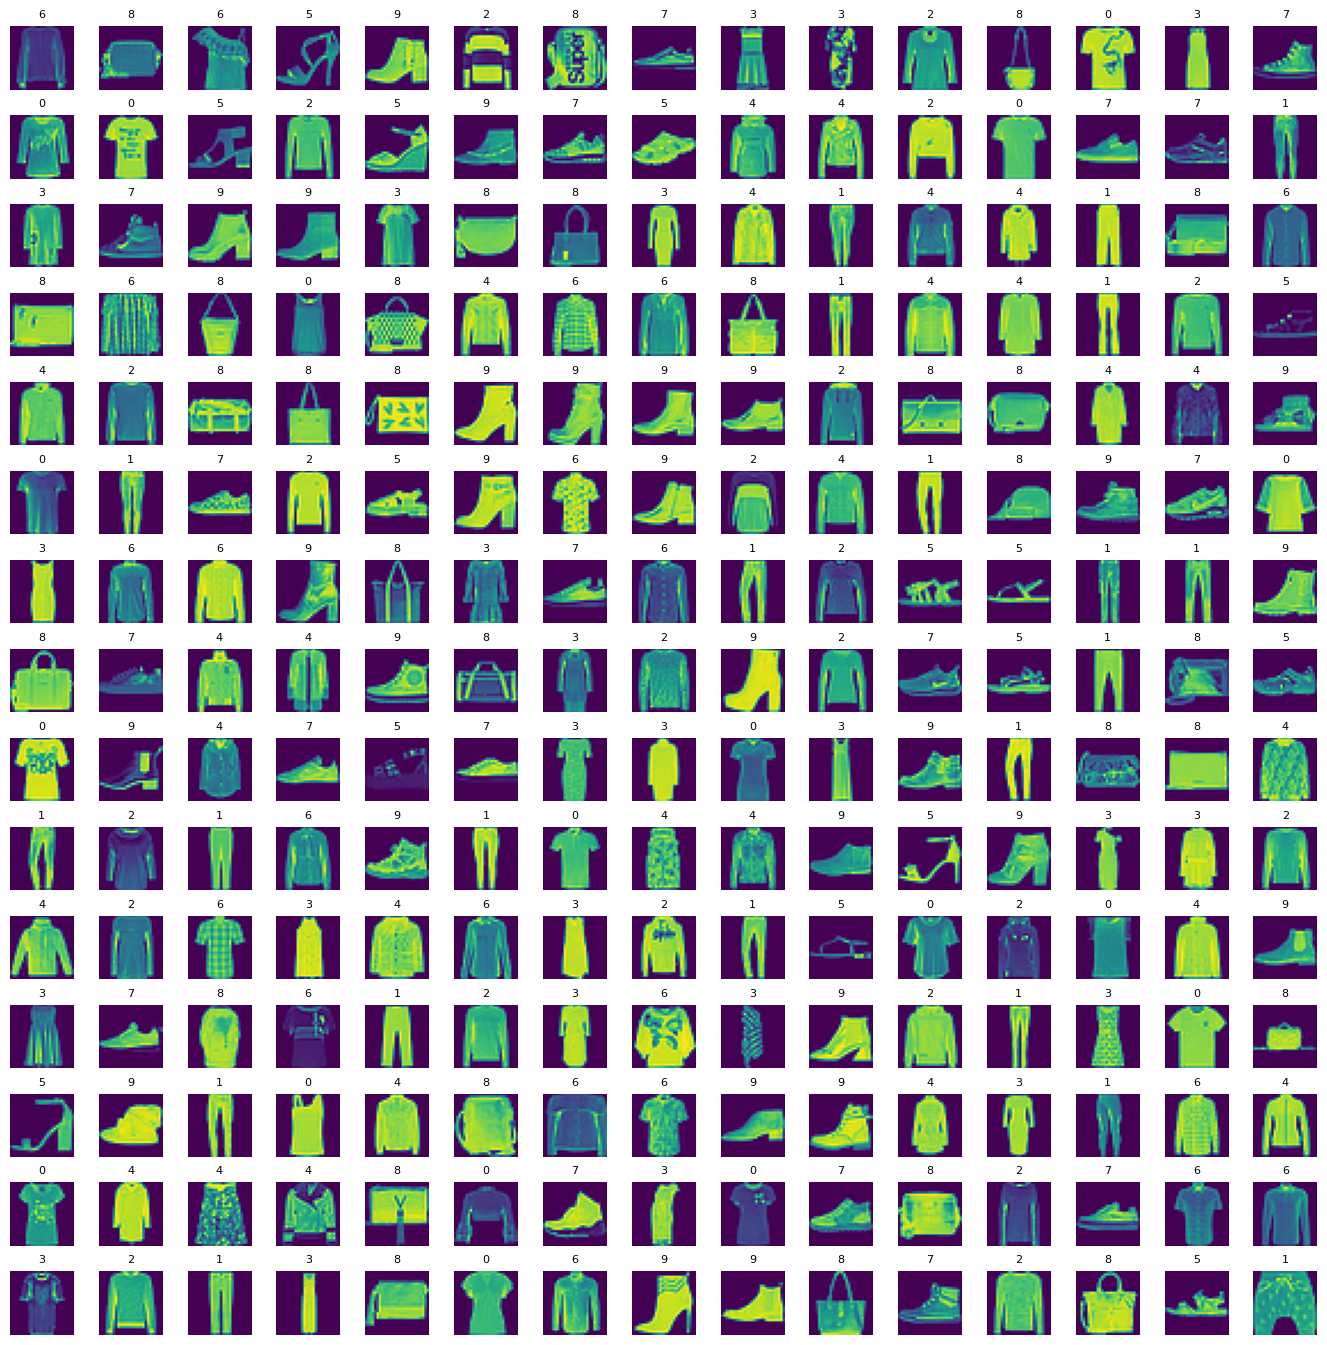

In [ ]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel()
n_training = len(X_train)

for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

# Etapa 4: Adição de ruído nas imagens

Normalizando


In [ ]:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
added_noise = np.random.randn(*(28,28))

In [ ]:
added_noise.shape

(28, 28)

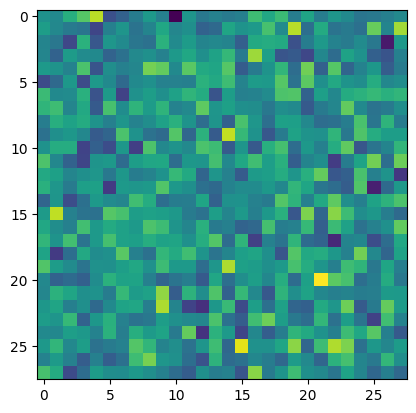

In [ ]:
plt.imshow(added_noise);

In [ ]:
noise_factor = 0.2
sample_image = X_train[10]
noisy_sample_image = sample_image + noise_factor * np.random.randn(*(28,28))

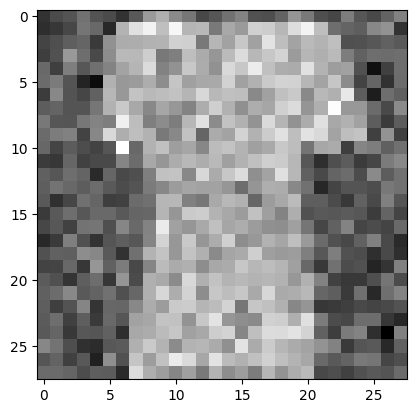

In [ ]:
plt.imshow(noisy_sample_image, cmap='gray');

Vamos observar os valores desses pixels e podemos notar que teremos que normalizar novamente

In [ ]:
noisy_sample_image.max()

1.2724211709799604

In [ ]:
noisy_sample_image.min()

-0.6811942434063494

In [ ]:
noisy_sample_image = np.clip(noisy_sample_image, 0., 1.)

In [ ]:
noisy_sample_image.max()

1.0

In [ ]:
noisy_sample_image.min()

0.0

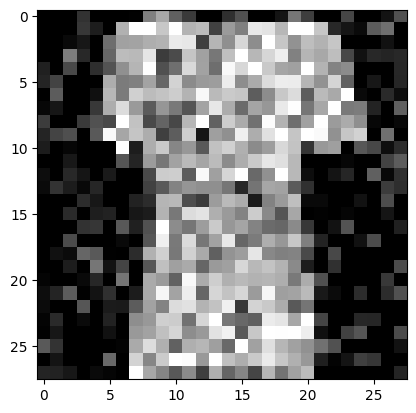

In [ ]:
plt.imshow(noisy_sample_image, cmap='gray');

Agora faremos isso em todas as imagens


In [ ]:
X_train_noisy = []
noise_factor = 0.2

for sample_image in X_train:
  sample_image_noisy = sample_image + noise_factor * np.random.randn(*(28,28))
  sample_image_noisy = np.clip(sample_image_noisy, 0., 1.)
  X_train_noisy.append(sample_image_noisy)

In [ ]:
type(X_train_noisy)

list

In [ ]:
X_train_noisy = np.array(X_train_noisy)
type(X_train_noisy)

numpy.ndarray

In [ ]:
X_train_noisy.shape

(60000, 28, 28)

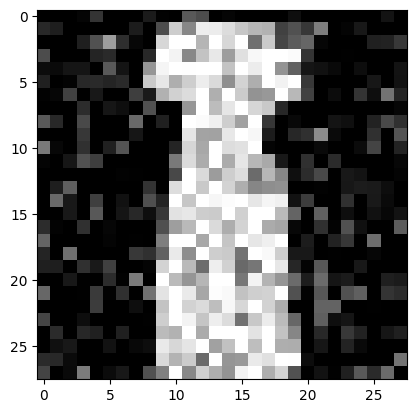

In [ ]:
plt.imshow(X_train_noisy[50], cmap='gray');

In [ ]:
X_test_noisy = []
noise_factor = 0.4

for sample_image in X_test:
  sample_image_noisy = sample_image + noise_factor * np.random.randn(*(28,28))
  sample_image_noisy = np.clip(sample_image_noisy, 0., 1.)
  X_test_noisy.append(sample_image_noisy)

In [ ]:
X_test_noisy = np.array(X_test_noisy)
type(X_test_noisy)

numpy.ndarray

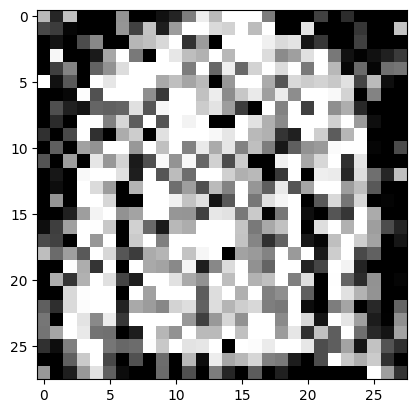

In [ ]:
plt.imshow(X_test_noisy[50], cmap='gray');

# Etapa 5: Criação e treinamento do modelo

In [ ]:
autoencoder = tf.keras.models.Sequential()

# Primeiro conjunto de camadas convolução e maxpooling para fazer a redução da dimensionalidade
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=1, padding='same', input_shape=(28,28,1)))
autoencoder.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

# Segundo conjunto de camadas convolução e maxpooling
autoencoder.add(tf.keras.layers.Conv2D(8, (3,3), strides=1, padding='same'))
autoencoder.add(tf.keras.layers.MaxPooling2D((2,2), padding='same'))

# Imagem codificada dentro de uma camada de convolução
autoencoder.add(tf.keras.layers.Conv2D(8, (3,3), strides=1, padding='same'))

# Decodificando a imagem
autoencoder.add(tf.keras.layers.UpSampling2D((2,2)))
autoencoder.add(tf.keras.layers.Conv2DTranspose(8, (3,3), strides=1, padding='same'))

autoencoder.add(tf.keras.layers.UpSampling2D((2,2)))
autoencoder.add(tf.keras.layers.Conv2DTranspose(1, (3,3), strides=1, padding='same', activation='sigmoid'))

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 8)         0

In [ ]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
autoencoder.fit(X_train_noisy.reshape(-1, 28, 28, 1),
                X_train.reshape(-1, 28, 28, 1),
                epochs = 25,
                batch_size = 200)

Epoch 1/25
300/300 [==============================] - 1s 5ms/step - loss: 0.2849
Epoch 2/25
300/300 [==============================] - 2s 5ms/step - loss: 0.2847
Epoch 3/25
300/300 [==============================] - 2s 6ms/step - loss: 0.2848
Epoch 4/25
300/300 [==============================] - 1s 4ms/step - loss: 0.2846
Epoch 5/25
300/300 [==============================] - 1s 4ms/step - loss: 0.2845
Epoch 6/25
300/300 [==============================] - 1s 4ms/step - loss: 0.2846
Epoch 7/25
300/300 [==============================] - 1s 4ms/step - loss: 0.2845
Epoch 8/25
300/300 [==============================] - 1s 4ms/step - loss: 0.2844
Epoch 9/25
300/300 [==============================] - 1s 4ms/step - loss: 0.2844
Epoch 10/25
300/300 [==============================] - 1s 4ms/step - loss: 0.2843
Epoch 11/25
300/300 [==============================] - 2s 5ms/step - loss: 0.2844
Epoch 12/25
300/300 [==============================] - 2s 6ms/step - loss: 0.2842
Epoch 13/25
300/300 [====

# Etapa 6: Avaliação do modelo

In [ ]:
denoised_images = autoencoder.predict(X_test_noisy[:15].reshape(-1,28,28,1))

1/1 [==============================] - 0s 22ms/step


In [ ]:
denoised_images.shape

(15, 28, 28, 1)

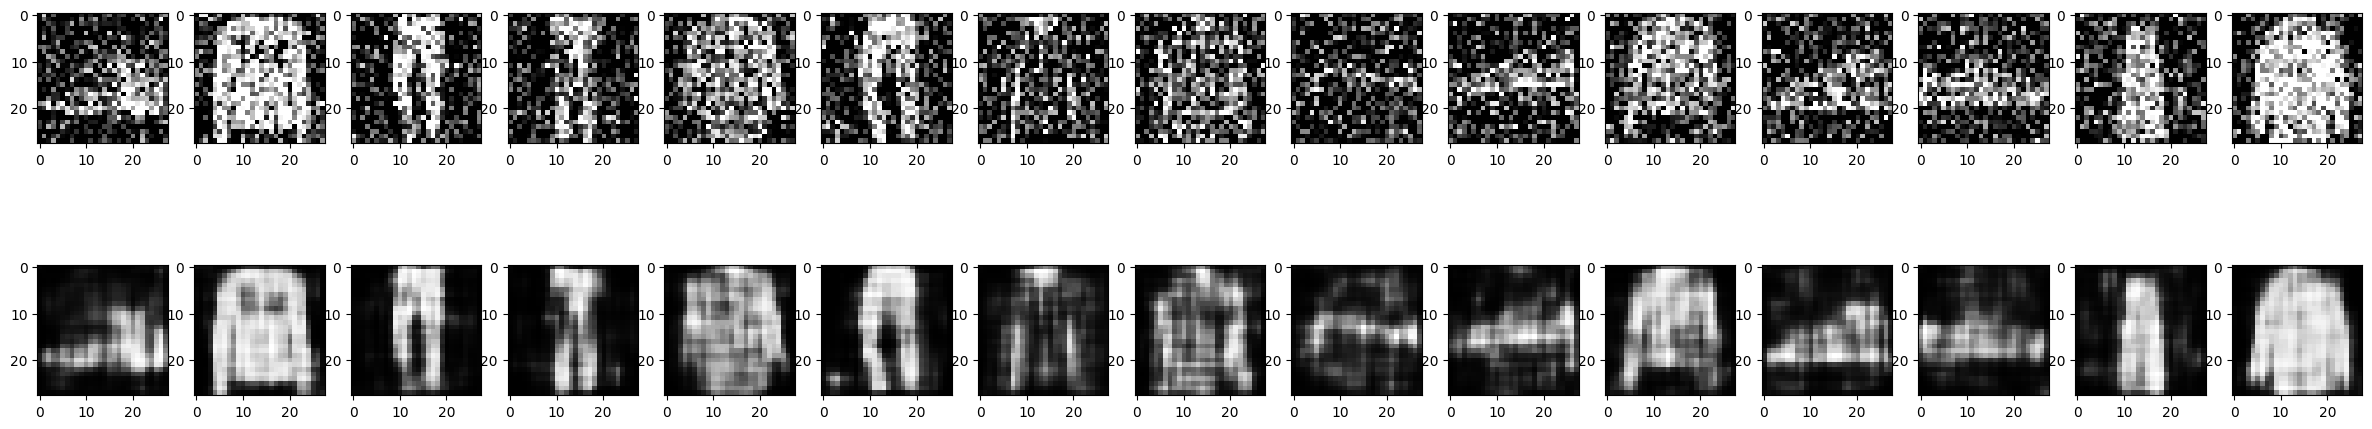

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=15, figsize=(30,6))
for images, row in zip([X_test_noisy[:15], denoised_images], axes):
  for img, ax in zip(images, row):
    ax.imshow(img.reshape((28,28)), cmap='gray')

# Etapa 7: Confirmação das dimensões

Notas:


*   Se stride = 1 e padding = same, as dimensões da saída serão iguais as dimensões da entrada. Exemplo:
> autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=1, padding="same", input_shape=(28, 28, 1)))
* Se stride = 2 e padding = same, as dimensões da saída serão menores (metade)
> autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=2, padding="same", input_shape=(28, 28, 1)))

* Padding = 'same' indica que preservaremos as dimensões de entrada
* Padding = 'valid' indica que perderemos um pouco de informação (não será adiciona preenchimento ao redor da imagem)




In [ ]:
# W = 28, F = 3, S = 1, Padding = same (P=F-1/2=1)
# o = (W-F+2*P/S) +1 = (28-3+2*1)/1 + 1 = 28
autoencoder = tf.keras.models.Sequential()
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=1, padding="same",
                                       input_shape=(28, 28, 1)))
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
Total params: 160 (640.00 Byte)
Trainable params: 160 (640.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# W = 28, F = 3, S = 2, Padding = same (P=F-1/2=1)
# o = (W-F+2*P/S) +1 = (28-3+2*1)/2 + 1 = 14
autoencoder = tf.keras.models.Sequential()
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=2, padding="same",
                                       input_shape=(28, 28, 1)))
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
Total params: 160 (640.00 Byte)
Trainable params: 160 (640.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Quando padding = valid, não são adicionadas "bordas" para preencher a imagem
# W = 28, F = 3, S = 1, Padding = valid (P=0)
# o = (W-F+2*P/S) +1 = (28-3+0)/1 + 1 = 26
autoencoder = tf.keras.models.Sequential()
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=1, padding="valid",
                                       input_shape=(28, 28, 1)))
autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
Total params: 160 (640.00 Byte)
Trainable params: 160 (640.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Quando padding = valid, não são adicionadas "bordas" para preencher a imagem
# W = 28, F = 3, S = 2, Padding = valid (P=0)
# o = (W-F+2*P/S) +1 = (28-3+0)/2 + 1 = 13
autoencoder = tf.keras.models.Sequential()
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=2, padding="valid",
                                       input_shape=(28, 28, 1)))
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 13, 13, 16)        160       
                                                                 
Total params: 160 (640.00 Byte)
Trainable params: 160 (640.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
